In [ ]:
import sys
import os

import matplotlib.pyplot as plt
import matplotlib_utils
from wandb_utils import *
from pandas_utils import *
import matplotlib
import numpy as np
from itertools import product
import pandas as pd

from matplotlib.gridspec import *

In [218]:
def select(df, selection):
    new_df = df.copy()
    for key, value in selection.items():
        if isinstance(value, list):
            new_df = new_df[new_df[key].isin(value)]
        else:
            new_df = new_df[new_df[key] == value]
    return new_df

def select_last_step(df, groupby, seed="seed", step="_step", val_loss="val/loss"):
    # For each groupby x seed, pick the last step for which the loss is not nan
    # Remove all lines with nan training loss
    df = df[df[val_loss].notna()]
    groups = df.groupby(groupby + [seed])
    last_steps = []
    for name, group in groups:
        last_step = group.loc[group[step].idxmax()]
        last_steps.append(last_step)
    return pd.DataFrame(last_steps)

def select_best_lr(df, keys, best_lrs, lr="training.learning_rate"):
    dfs = []
    for this_keys, this_lr in best_lrs.items():
        selection = {lr: this_lr}
        for key, this_key in zip(keys, this_keys):
            selection[key] = this_key
        dfs.append(select(df, selection))
    return pd.concat(dfs)

def find_best_lr(df, groupby, lr="training.learning_rate", metric="val/loss", step="_step"):
    # For each combinations in groupby, average the results, and find the best learning rate, the one that minimize the metric at the final time step
    df = select_last_step(df, groupby + [lr])
    df = df.groupby(groupby + [lr])[["val/loss"]].mean().reset_index()
    groups = df.groupby(groupby)
    best_lrs = {}
    for name, group in groups:
        best_lr = group.loc[group[metric].idxmin(), lr]
        best_lrs[name] = best_lr
    return best_lrs

## Shallow models

In [219]:
results = load_sweep("nzucchet/online-bptt/uksrvrcj")

In [220]:
groupby = ["model.training_mode", "model.lru_r_min"]
learning_rate = "training.learning_rate"
df = select_last_step(results, groupby + [learning_rate])
best_lrs = find_best_lr(df, groupby)
best_results = select_best_lr(df, groupby, best_lrs)[groupby + ["val/loss", "val/acc"]]
best_results.groupby(groupby).mean().reset_index()

,model.training_mode,model.lru_r_min,val/loss,val/acc
0,forward,0.90,2.074513,0.292098
1,forward,0.99,1.597095,0.577760
2,forward_forward,0.90,0.857835,0.955679
3,forward_forward,0.99,0.820613,0.953954
4,normal,0.90,0.772239,0.970608
5,normal,0.99,0.744038,0.968717
6,spatial,0.90,0.857996,0.954054
7,spatial,0.99,0.826995,0.958367


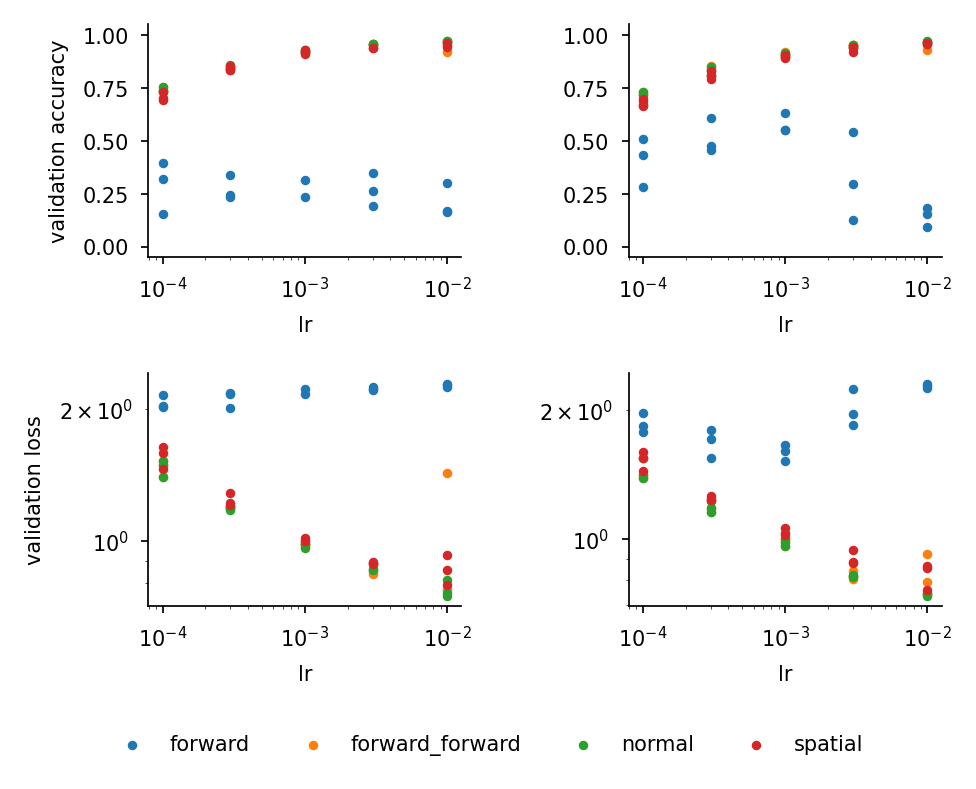

In [221]:
groupby = ["model.training_mode", "model.lru_r_min"]
learning_rate = "training.learning_rate"
df = select_last_step(results, groupby + [learning_rate])

fig, ax = plt.subplots(2, 2, figsize=(4, 3))
for i, r_min in enumerate(df["model.lru_r_min"].unique()):
    for training_mode in df["model.training_mode"].unique():
        this_df = select(df, {"model.lru_r_min": r_min, "model.training_mode": training_mode})
        ax[0][i].scatter(this_df[learning_rate], this_df["val/acc"], s=3, label=training_mode)
        ax[1][i].scatter(this_df[learning_rate], this_df["val/loss"], s=3, label=training_mode)
    ax[0][i].set_xscale("log")
    ax[0][i].set_xlabel("lr")
    ax[0][i].set_ylim(-0.05, 1.05)
    ax[1][i].set_xscale("log")
    ax[1][i].set_xlabel("lr")
    ax[1][i].set_yscale("log")

# Build a single legend below both axes, centered
handles, labels = [], []
for a in ax[1]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
seen = set()
unique = []
for h, l in zip(handles, labels):
    if l not in seen:
        unique.append((h, l))
        seen.add(l)
if unique:
    handles, labels = zip(*unique)
    fig.legend(handles, labels, loc="lower center", ncol=4, fontsize=6, bbox_to_anchor=(0.5, -0.05), frameon=False)

ax[0][0].set_ylabel("validation accuracy")
ax[1][0].set_ylabel("validation loss")

# Tight layout with bottom margin for the legend
plt.tight_layout(rect=[0, 0.02, 1, 1], w_pad=2)

## Comparison, deep models (2 layers)

In [222]:
results = load_sweep("nzucchet/online-bptt/1x0swk5c")


In [224]:
groupby = ["model.training_mode", "model.lru_r_min"]
learning_rate = "training.learning_rate"
best_lrs = find_best_lr(results, groupby)
df = select_last_step(results, groupby + [learning_rate])
best_results = select_best_lr(df, groupby, best_lrs)[groupby + ["val/loss", "val/acc"]]
best_results.groupby(groupby).mean().reset_index()

,model.training_mode,model.lru_r_min,val/loss,val/acc
0,forward,0.90,2.291927,0.138071
1,forward,0.99,2.203892,0.219579
2,forward_forward,0.90,0.743206,0.971902
3,forward_forward,0.99,0.697199,0.977044
4,normal,0.90,0.681127,0.982617
5,normal,0.99,0.698681,0.979333
6,spatial,0.90,0.730706,0.965516
7,spatial,0.99,0.848546,0.913150


0
1


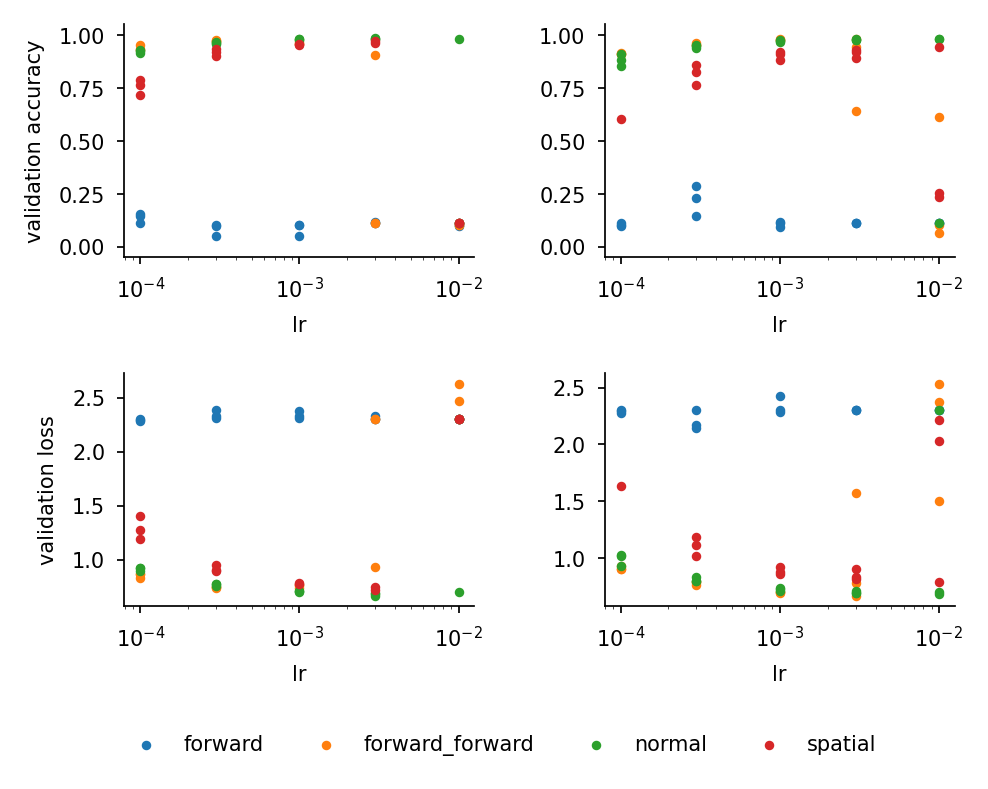

In [228]:
groupby = ["model.training_mode", "model.lru_r_min"]
learning_rate = "training.learning_rate"
df = select_last_step(results, groupby + [learning_rate])

fig, ax = plt.subplots(2, 2, figsize=(4, 3))
for i, r_min in enumerate(df["model.lru_r_min"].unique()):
    print(i)
    for training_mode in df["model.training_mode"].unique():
        this_df = select(df, {"model.lru_r_min": r_min, "model.training_mode": training_mode})
        ax[0][i].scatter(this_df[learning_rate], this_df["val/acc"], s=3, label=training_mode)
        ax[1][i].scatter(this_df[learning_rate], this_df["val/loss"], s=3, label=training_mode)
    ax[0][i].set_xscale("log")
    ax[0][i].set_xlabel("lr")
    ax[0][i].set_ylim(-0.05, 1.05)
    ax[1][i].set_xscale("log")
    ax[1][i].set_xlabel("lr")

# Build a single legend below both axes, centered
handles, labels = [], []
for a in ax[1]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
seen = set()
unique = []
for h, l in zip(handles, labels):
    if l not in seen:
        unique.append((h, l))
        seen.add(l)
if unique:
    handles, labels = zip(*unique)
    fig.legend(handles, labels, loc="lower center", ncol=4, fontsize=6, bbox_to_anchor=(0.5, -0.05), frameon=False)

ax[0][0].set_ylabel("validation accuracy")
ax[1][0].set_ylabel("validation loss")

# Tight layout with bottom margin for the legend
plt.tight_layout(rect=[0, 0.02, 1, 1], w_pad=2)

## Ablation number forward passes (4 layers)

In [229]:
results = load_sweep("nzucchet/online-bptt/yp0vpblj")

In [230]:
groupby = ["model.forward_simulation_passes"]
learning_rate = "training.learning_rate"
df = select_last_step(results, groupby + [learning_rate])
best_lrs = find_best_lr(df, groupby)
best_results = select_best_lr(df, groupby, best_lrs)[groupby + ["val/loss", "val/acc"]]
best_results.groupby(groupby).mean().reset_index()

,model.forward_simulation_passes,val/loss,val/acc
0,1,0.784742,0.942178
1,2,0.740301,0.961883
2,3,0.748949,0.963475
3,4,0.725482,0.971271
4,5,0.705072,0.972996


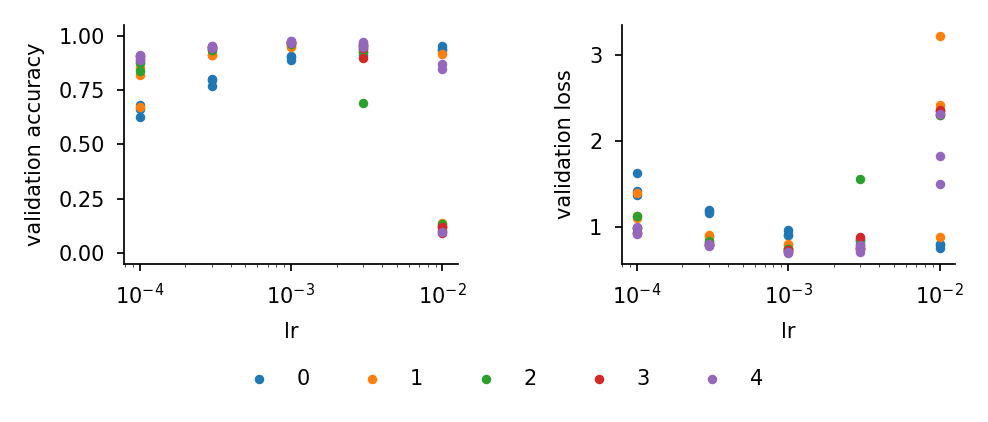

In [231]:
groupby = ["model.forward_simulation_passes"]
learning_rate = "training.learning_rate"
df = select_last_step(results, groupby + [learning_rate])

fig, ax = plt.subplots(1, 2, figsize=(4, 1.6))
for i, passes in enumerate(df["model.forward_simulation_passes"].unique()):
    this_df = select(df, {"model.forward_simulation_passes": passes})
    ax[0].scatter(this_df[learning_rate], this_df["val/acc"], s=3, label=i)
    ax[1].scatter(this_df[learning_rate], this_df["val/loss"], s=3, label=i)
ax[0].set_xscale("log")
ax[0].set_xlabel("lr")
ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xscale("log")
ax[1].set_xlabel("lr")

# Build a single legend below both axes, centered
handles, labels = [], []
for a in ax:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
seen = set()
unique = []
for h, l in zip(handles, labels):
    if l not in seen:
        unique.append((h, l))
        seen.add(l)
if unique:
    handles, labels = zip(*unique)
    fig.legend(handles, labels, loc="lower center", ncol=5, fontsize=6, bbox_to_anchor=(0.5, -0.05), frameon=False)

ax[0].set_ylabel("validation accuracy")
ax[1].set_ylabel("validation loss")

# Tight layout with bottom margin for the legend
plt.tight_layout(rect=[0, 0.02, 1, 1], w_pad=2)

## FUll MNIST, comparison

In [233]:
results = pd.concat([
    load_sweep("nzucchet/online-bptt/vcofbt5x"),
    load_sweep("nzucchet/online-bptt/ay6ll858"),
])

In [234]:
groupby = ["model.training_mode", "model.lru_r_min"]
learning_rate = "training.learning_rate"
best_lrs = find_best_lr(results, groupby)
df = select_last_step(results, groupby + [learning_rate])
best_results = select_best_lr(df, groupby, best_lrs)[groupby + ["val/loss", "val/acc"]]
best_results.groupby(groupby).mean().reset_index()

,model.training_mode,model.lru_r_min,val/loss,val/acc
0,forward,0.990,2.125356,0.314457
1,forward,0.999,1.978657,0.361332
2,forward_forward,0.990,0.716111,0.968617
3,forward_forward,0.999,0.709317,0.965134
4,normal,0.990,0.649978,0.981058
5,normal,0.999,0.649314,0.982152
6,spatial,0.990,0.723215,0.960423
7,spatial,0.999,0.797820,0.925159


0
1


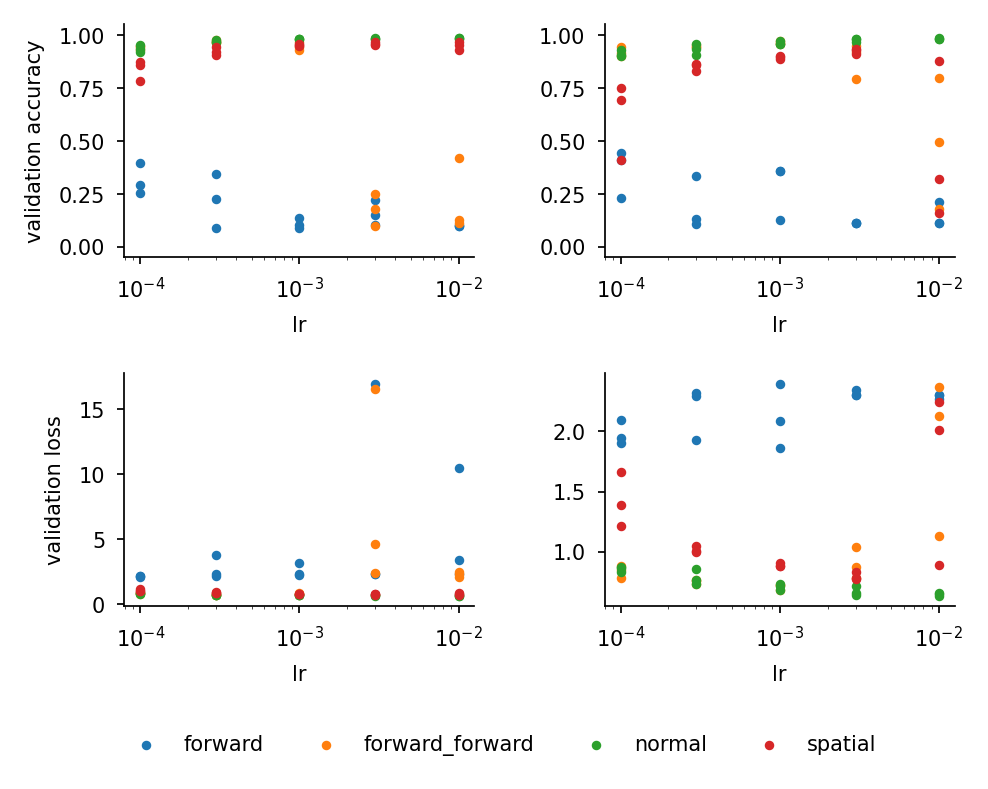

In [235]:
groupby = ["model.training_mode", "model.lru_r_min"]
learning_rate = "training.learning_rate"
df = select_last_step(results, groupby + [learning_rate])

fig, ax = plt.subplots(2, 2, figsize=(4, 3))
for i, r_min in enumerate(df["model.lru_r_min"].unique()):
    print(i)
    for training_mode in df["model.training_mode"].unique():
        this_df = select(df, {"model.lru_r_min": r_min, "model.training_mode": training_mode})
        ax[0][i].scatter(this_df[learning_rate], this_df["val/acc"], s=3, label=training_mode)
        ax[1][i].scatter(this_df[learning_rate], this_df["val/loss"], s=3, label=training_mode)
    ax[0][i].set_xscale("log")
    ax[0][i].set_xlabel("lr")
    ax[0][i].set_ylim(-0.05, 1.05)
    ax[1][i].set_xscale("log")
    ax[1][i].set_xlabel("lr")

# Build a single legend below both axes, centered
handles, labels = [], []
for a in ax[1]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
seen = set()
unique = []
for h, l in zip(handles, labels):
    if l not in seen:
        unique.append((h, l))
        seen.add(l)
if unique:
    handles, labels = zip(*unique)
    fig.legend(handles, labels, loc="lower center", ncol=4, fontsize=6, bbox_to_anchor=(0.5, -0.05), frameon=False)

ax[0][0].set_ylabel("validation accuracy")
ax[1][0].set_ylabel("validation loss")

# Tight layout with bottom margin for the legend
plt.tight_layout(rect=[0, 0.02, 1, 1], w_pad=2)